In [1]:
# Install necessary packages if needed
# !pip install scanpy matplotlib seaborn pandas numpy anndata

# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plotting settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, frameon=False)

BASE_DIR = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA"

In [2]:
samples = {
    "Emx1_Ctrl": "cellranger_counts_R26_Emx1_Ctrl_adult_0",
    "Emx1_Mut": "cellranger_counts_R26_Emx1_Mut_adult_1",
    "Nestin_Ctrl": "cellranger_counts_R26_Nestin_Ctrl_adult_2",
    "Nestin_Mut": "cellranger_counts_R26_Nestin_Mut_adult_3"
    }

# 1. Setup and Data Loading

In [3]:
# Path to the matrix files
CELL_DATA_DIR = "cellranger_final_count_data"
# Change to Nestin_Mut which exists according to file_context_0
SAMPLE = samples["Emx1_Mut"]
matrix_dir = os.path.join(BASE_DIR, CELL_DATA_DIR, SAMPLE, "outs", "filtered_feature_bc_matrix")

# Load the data from the filtered matrix
adata = sc.read_10x_mtx(
    matrix_dir,
    var_names='gene_symbols',
    cache=True
)

# Basic information
print(f"Shape of loaded data: {adata.shape}")  # cells × genes

... writing an h5ad cache file to speedup reading next time
Shape of loaded data: (367, 33696)


# 2. Basic Pre-processing

filtered out 16108 genes that are detected in less than 3 cells


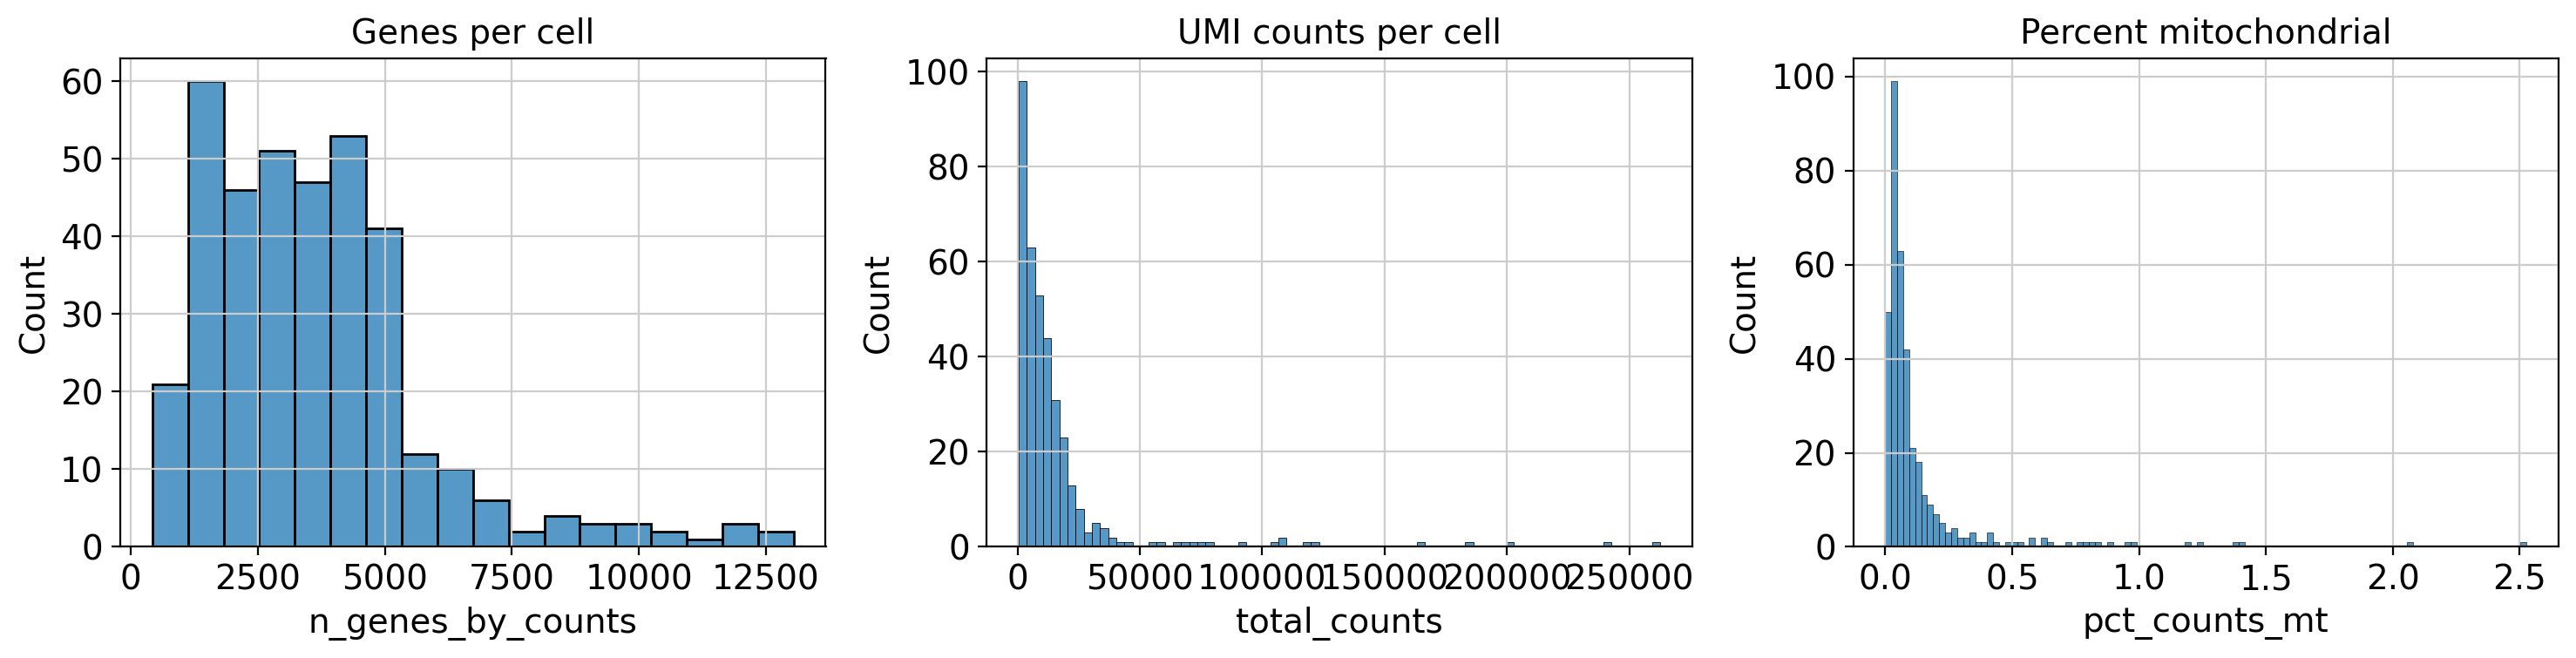

In [4]:
# Make a copy of the raw counts
adata.raw = adata.copy()

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot QC metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(adata.obs['n_genes_by_counts'], kde=False, ax=axs[0])
axs[0].set_title('Genes per cell')
sns.histplot(adata.obs['total_counts'], kde=False, ax=axs[1])
axs[1].set_title('UMI counts per cell')
sns.histplot(adata.obs['pct_counts_mt'], kde=False, ax=axs[2])
axs[2].set_title('Percent mitochondrial')
plt.tight_layout()
plt.show()

# 3. Filtering Based on QC Metrics

In [5]:
max_genes = 8000 
min_genes = 500  
max_mt_pct = 20  

adata = adata[adata.obs['n_genes_by_counts'] < max_genes, :]
adata = adata[adata.obs['n_genes_by_counts'] > min_genes, :]
adata = adata[adata.obs['pct_counts_mt'] < max_mt_pct, :]

print(f"Number of cells after filtering: {adata.n_obs}")
print(f"Number of genes after filtering: {adata.n_vars}")

Number of cells after filtering: 346
Number of genes after filtering: 17588


# 4. Normalization and Log Transformation

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of highly variable genes: 4490


/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<Figure size 1000x800 with 0 Axes>

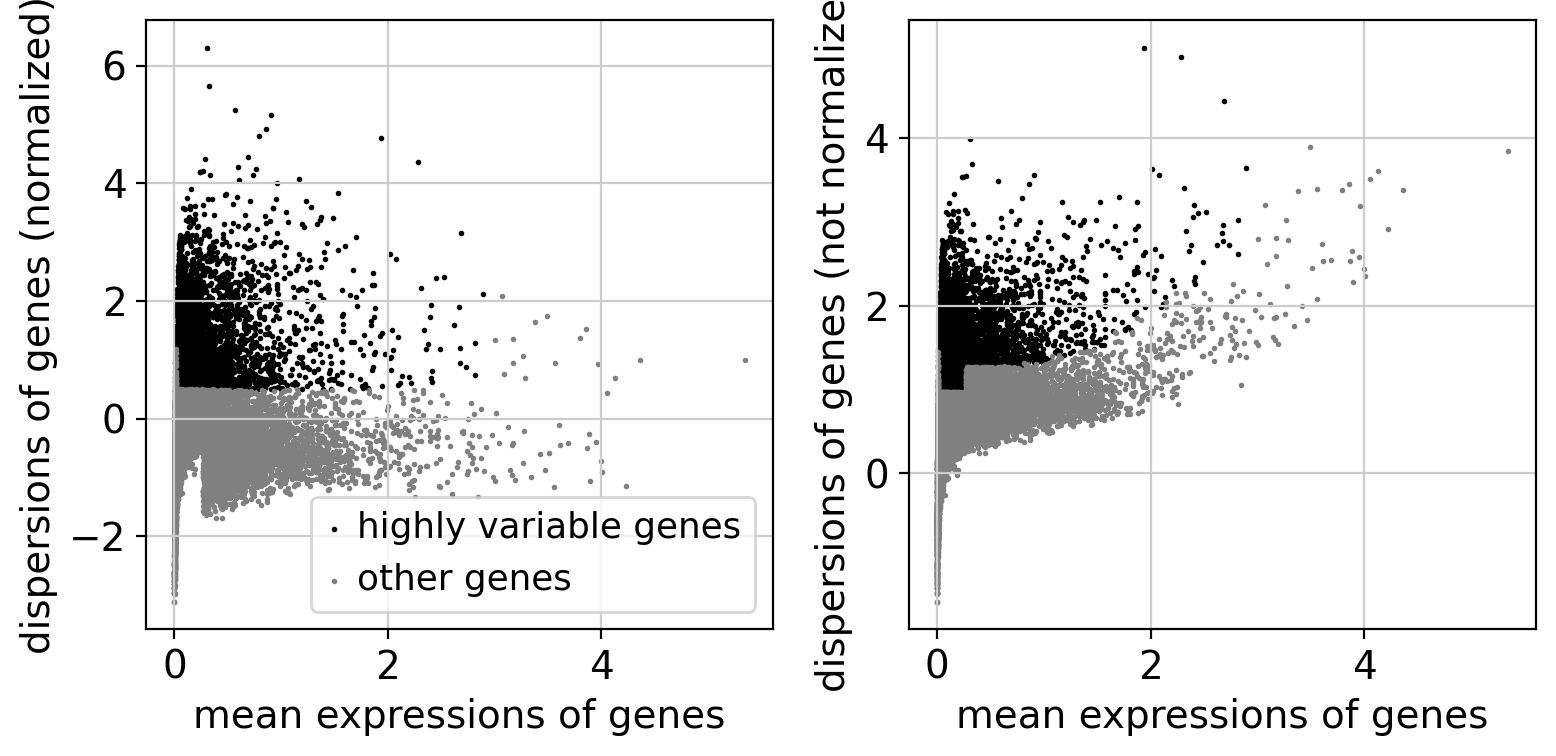

In [6]:
# Normalize to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f"Number of highly variable genes: {sum(adata.var.highly_variable)}")

# Plot highly variable genes
plt.figure(figsize=(10, 8))
sc.pl.highly_variable_genes(adata, show=False)
plt.tight_layout()
plt.show()

# Keep only highly variable genes for dimensionality reduction
adata_hvg = adata[:, adata.var.highly_variable]

# 5. Dimensionality Reduction

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50


/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:29)


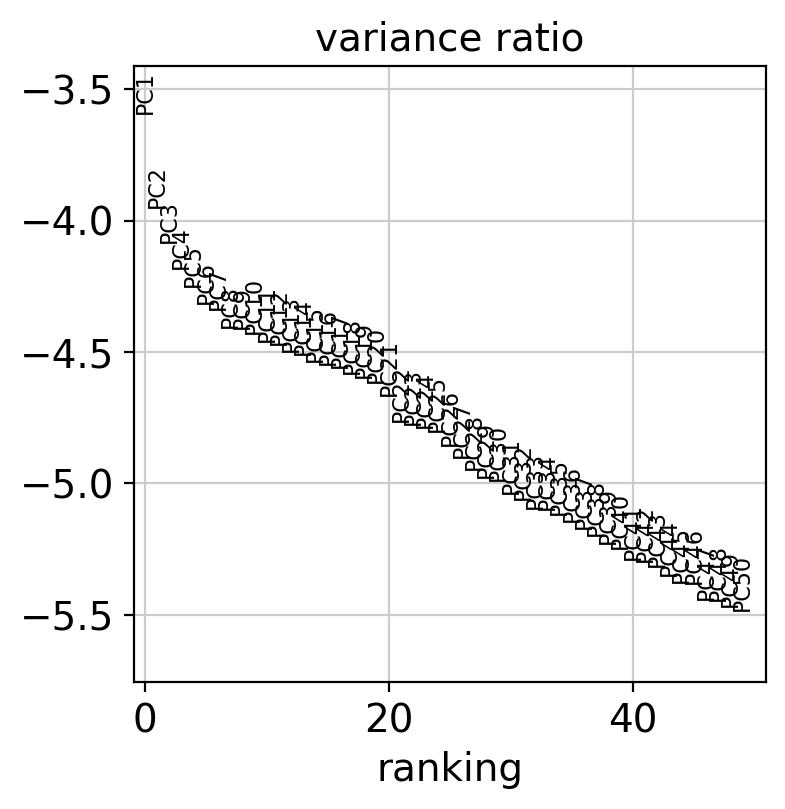

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


/tmp/ipykernel_1946436/3709656582.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

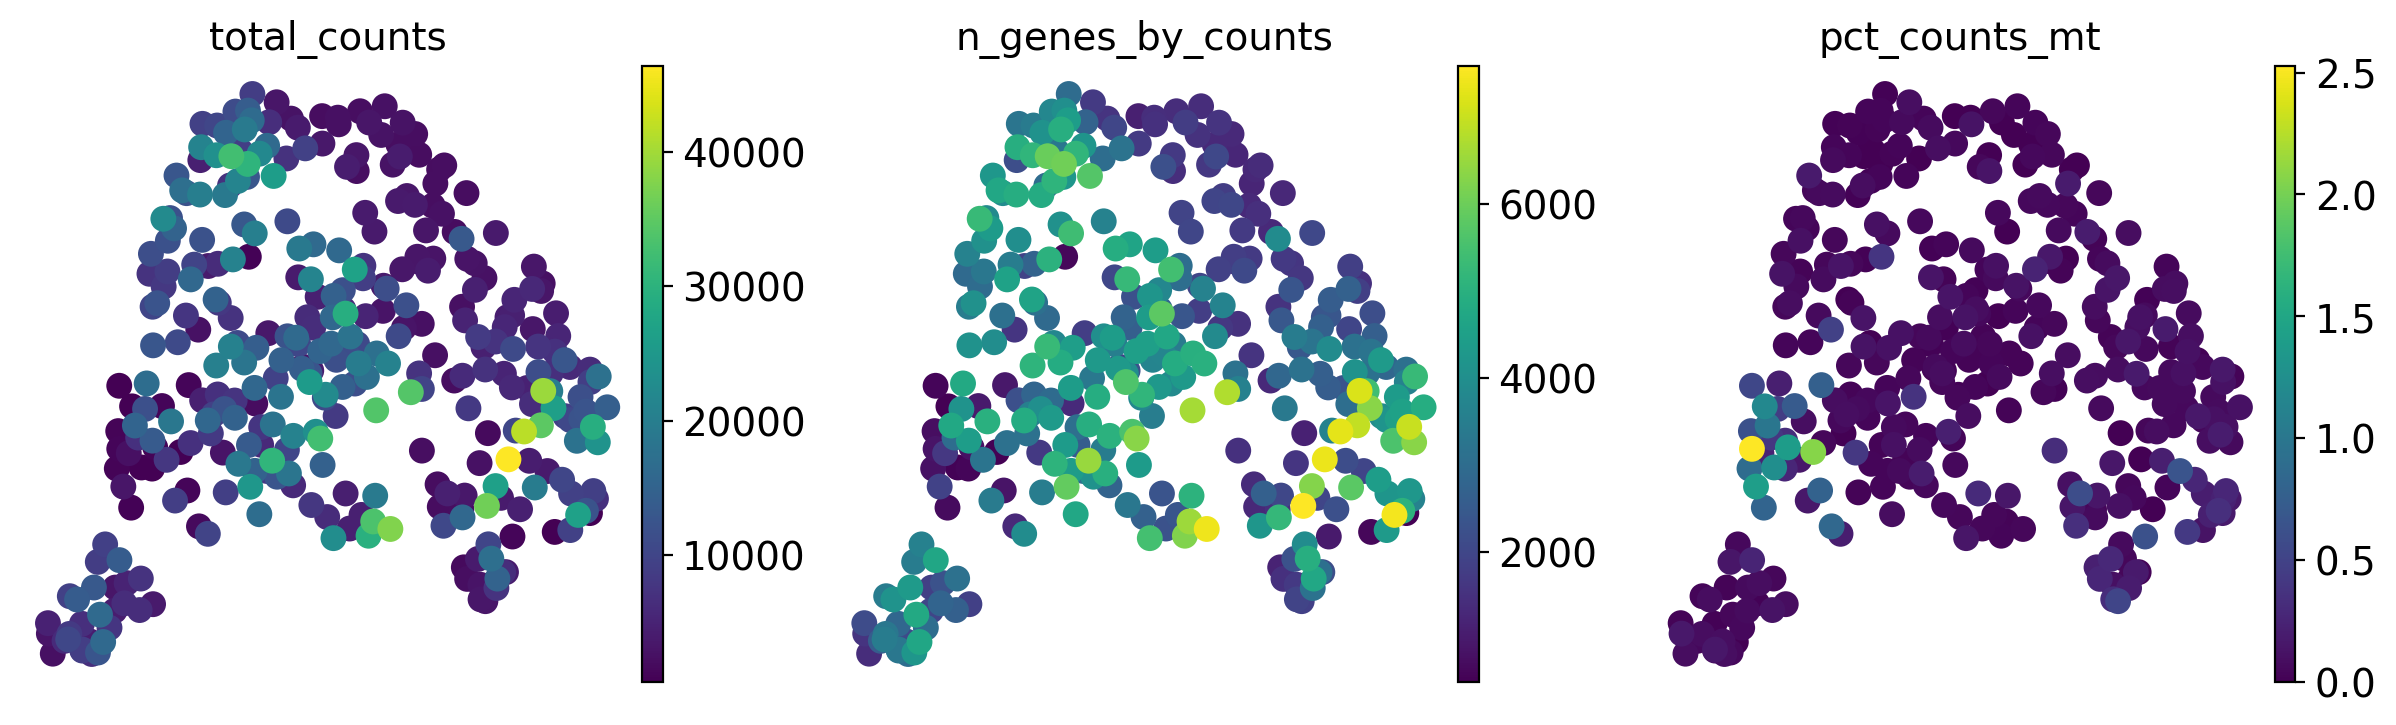

In [7]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata_hvg, max_value=10)

# Run PCA
sc.tl.pca(adata_hvg, svd_solver='arpack')

# Determine number of significant PCs
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50, log=True)
plt.show()

# Choose number of PCs for downstream analyses
n_pcs = 30  # Adjust based on the variance ratio plot

# Compute neighborhood graph
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata_hvg)

# Plot UMAP
plt.figure(figsize=(10, 8))
sc.pl.umap(adata_hvg, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
           use_raw=False, color_map='viridis', show=False)
plt.tight_layout()
plt.show()

# 6. Clustering

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_1946436/4234642825.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=0.5)  # Adjust resolution as needed


<Figure size 1000x800 with 0 Axes>

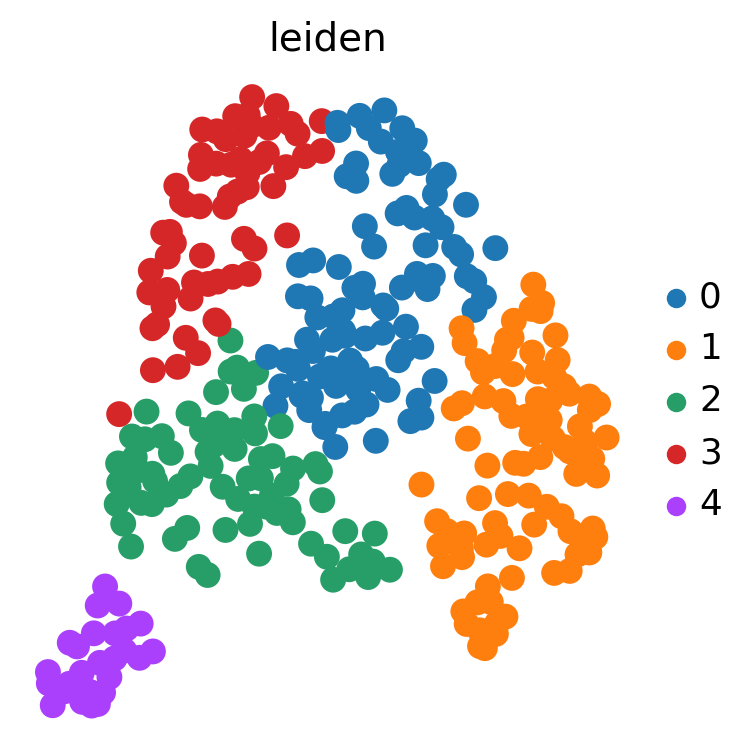

leiden
0    95
1    91
2    72
3    60
4    28
Name: count, dtype: int64
running Leiden clustering
    finished: found 2 clusters and added
    'leiden_res0.1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.7', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res1.0', the cluster labels (adata.obs, categorical) (0:00:00)


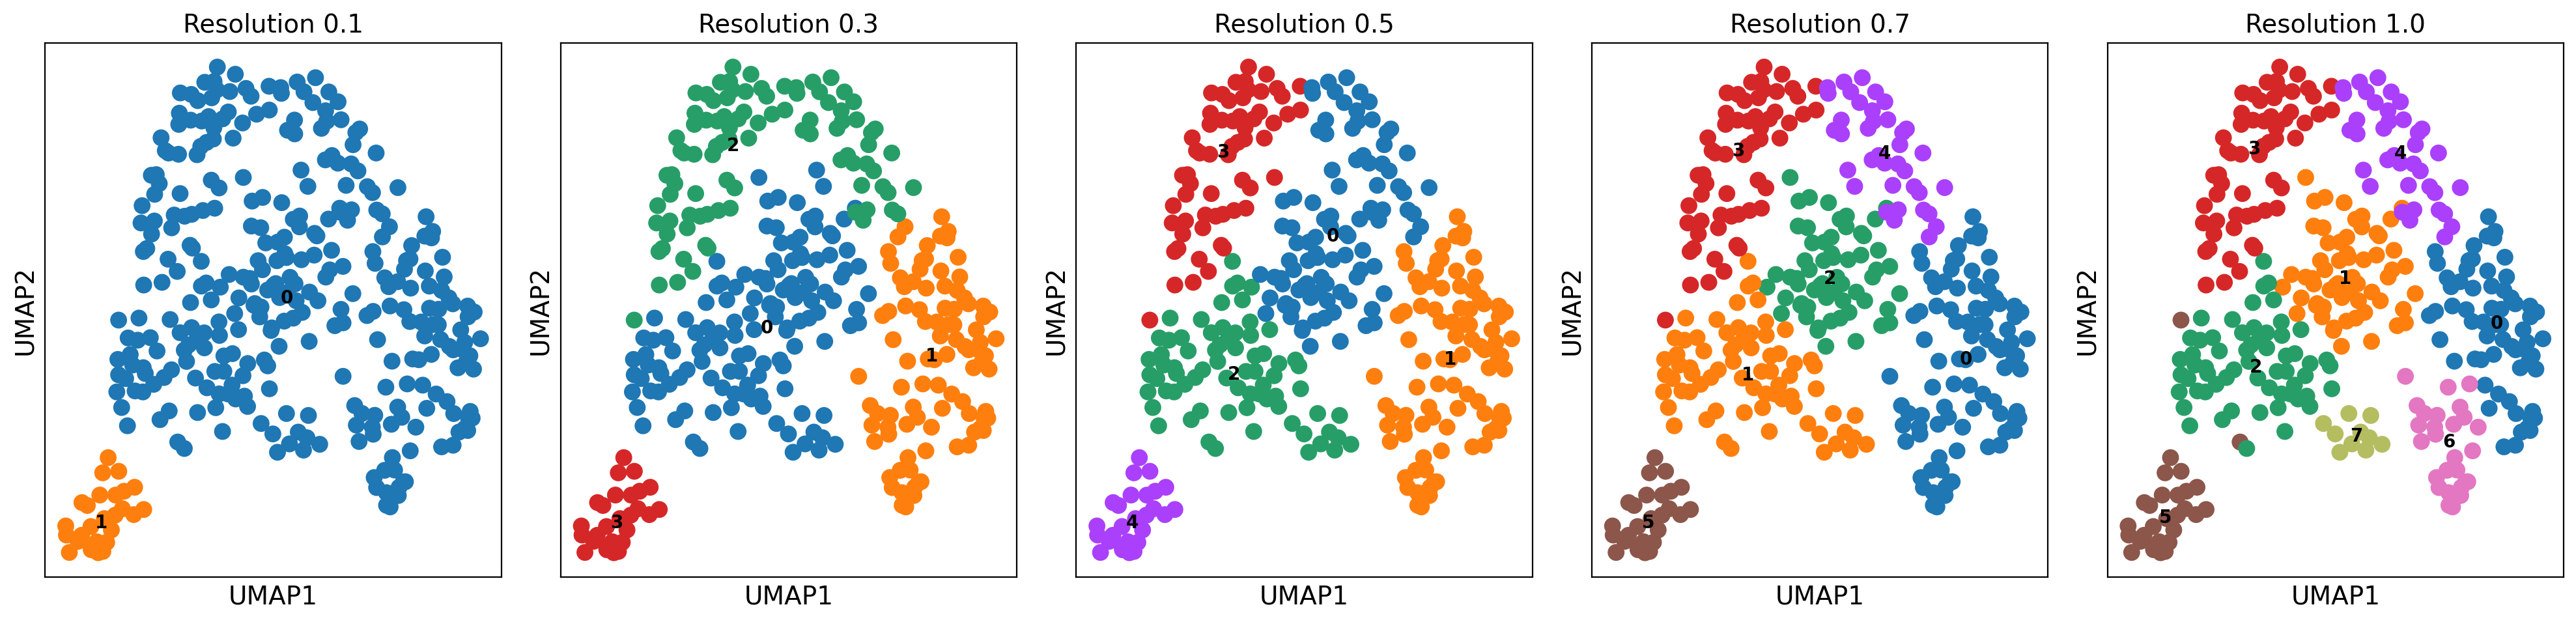

In [8]:
# Find clusters using Leiden algorithm
sc.tl.leiden(adata_hvg, resolution=0.5)  # Adjust resolution as needed

# Plot clusters on UMAP
plt.figure(figsize=(10, 8))
sc.pl.umap(adata_hvg, color='leiden', show=False)
plt.tight_layout()
plt.show()

# Check cluster sizes
cluster_counts = adata_hvg.obs['leiden'].value_counts()
print(cluster_counts)

# Try different resolutions to find optimal number of clusters
resolutions = [0.1, 0.3, 0.5, 0.7, 1.0]
for res in resolutions:
    sc.tl.leiden(adata_hvg, resolution=res, key_added=f'leiden_res{res}')

# Plot clusters at different resolutions with improved layout
fig, axes = plt.subplots(1, len(resolutions), figsize=(20, 5))
for i, res in enumerate(resolutions):
    sc.pl.umap(adata_hvg, color=f'leiden_res{res}', title=f'Resolution {res}', 
               frameon=True, legend_loc='on data', legend_fontsize=10, ax=axes[i], show=False)

# Ensure proper spacing between subplots
plt.tight_layout()
plt.show()

# 7. Marker Gene Identification

In [9]:
print(adata_hvg.layers.keys())
print(adata_hvg)

KeysView(Layers with keys: )
AnnData object with n_obs × n_vars = 346 × 4490
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_res0.1', 'leiden_res0.3', 'leiden_res0.5', 'leiden_res0.7', 'leiden_res1.0'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_res0.1', 'leiden_res0.3', 'leiden_res0.5', 'leiden_res0.7', 'leiden_res1.0', 'leiden_res0.1_colors', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.7_colors', 'leiden_res1.0_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [10]:
from scipy.sparse import issparse
import numpy as np

# Check first 5 values from first cell
if issparse(adata_hvg.X):
    print("X matrix values (first cell):", adata_hvg.X[0, :5].toarray().flatten())
else:
    print("X matrix values (first cell):", adata_hvg.X[0, :5])
print("Should be log1p transformed values (~0-5 range)")

# Check raw values if raw exists
if adata_hvg.raw:
    if issparse(adata_hvg.raw.X):
        print("Raw values:", adata_hvg.raw.X[0, :5].toarray().flatten())
    else:
        print("Raw values:", adata_hvg.raw.X[0, :5])
    print("Should be original counts (integers)")

X matrix values (first cell): [-0.4907744  -0.5513679  -0.16724029 -0.19451249 -0.20548835]
Should be log1p transformed values (~0-5 range)
Raw values: [13.  0.  0.  0.  0.]
Should be original counts (integers)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/beegfs/scratch/ric.broccoli/kubacki.michal/cond

<Figure size 1500x1000 with 0 Axes>

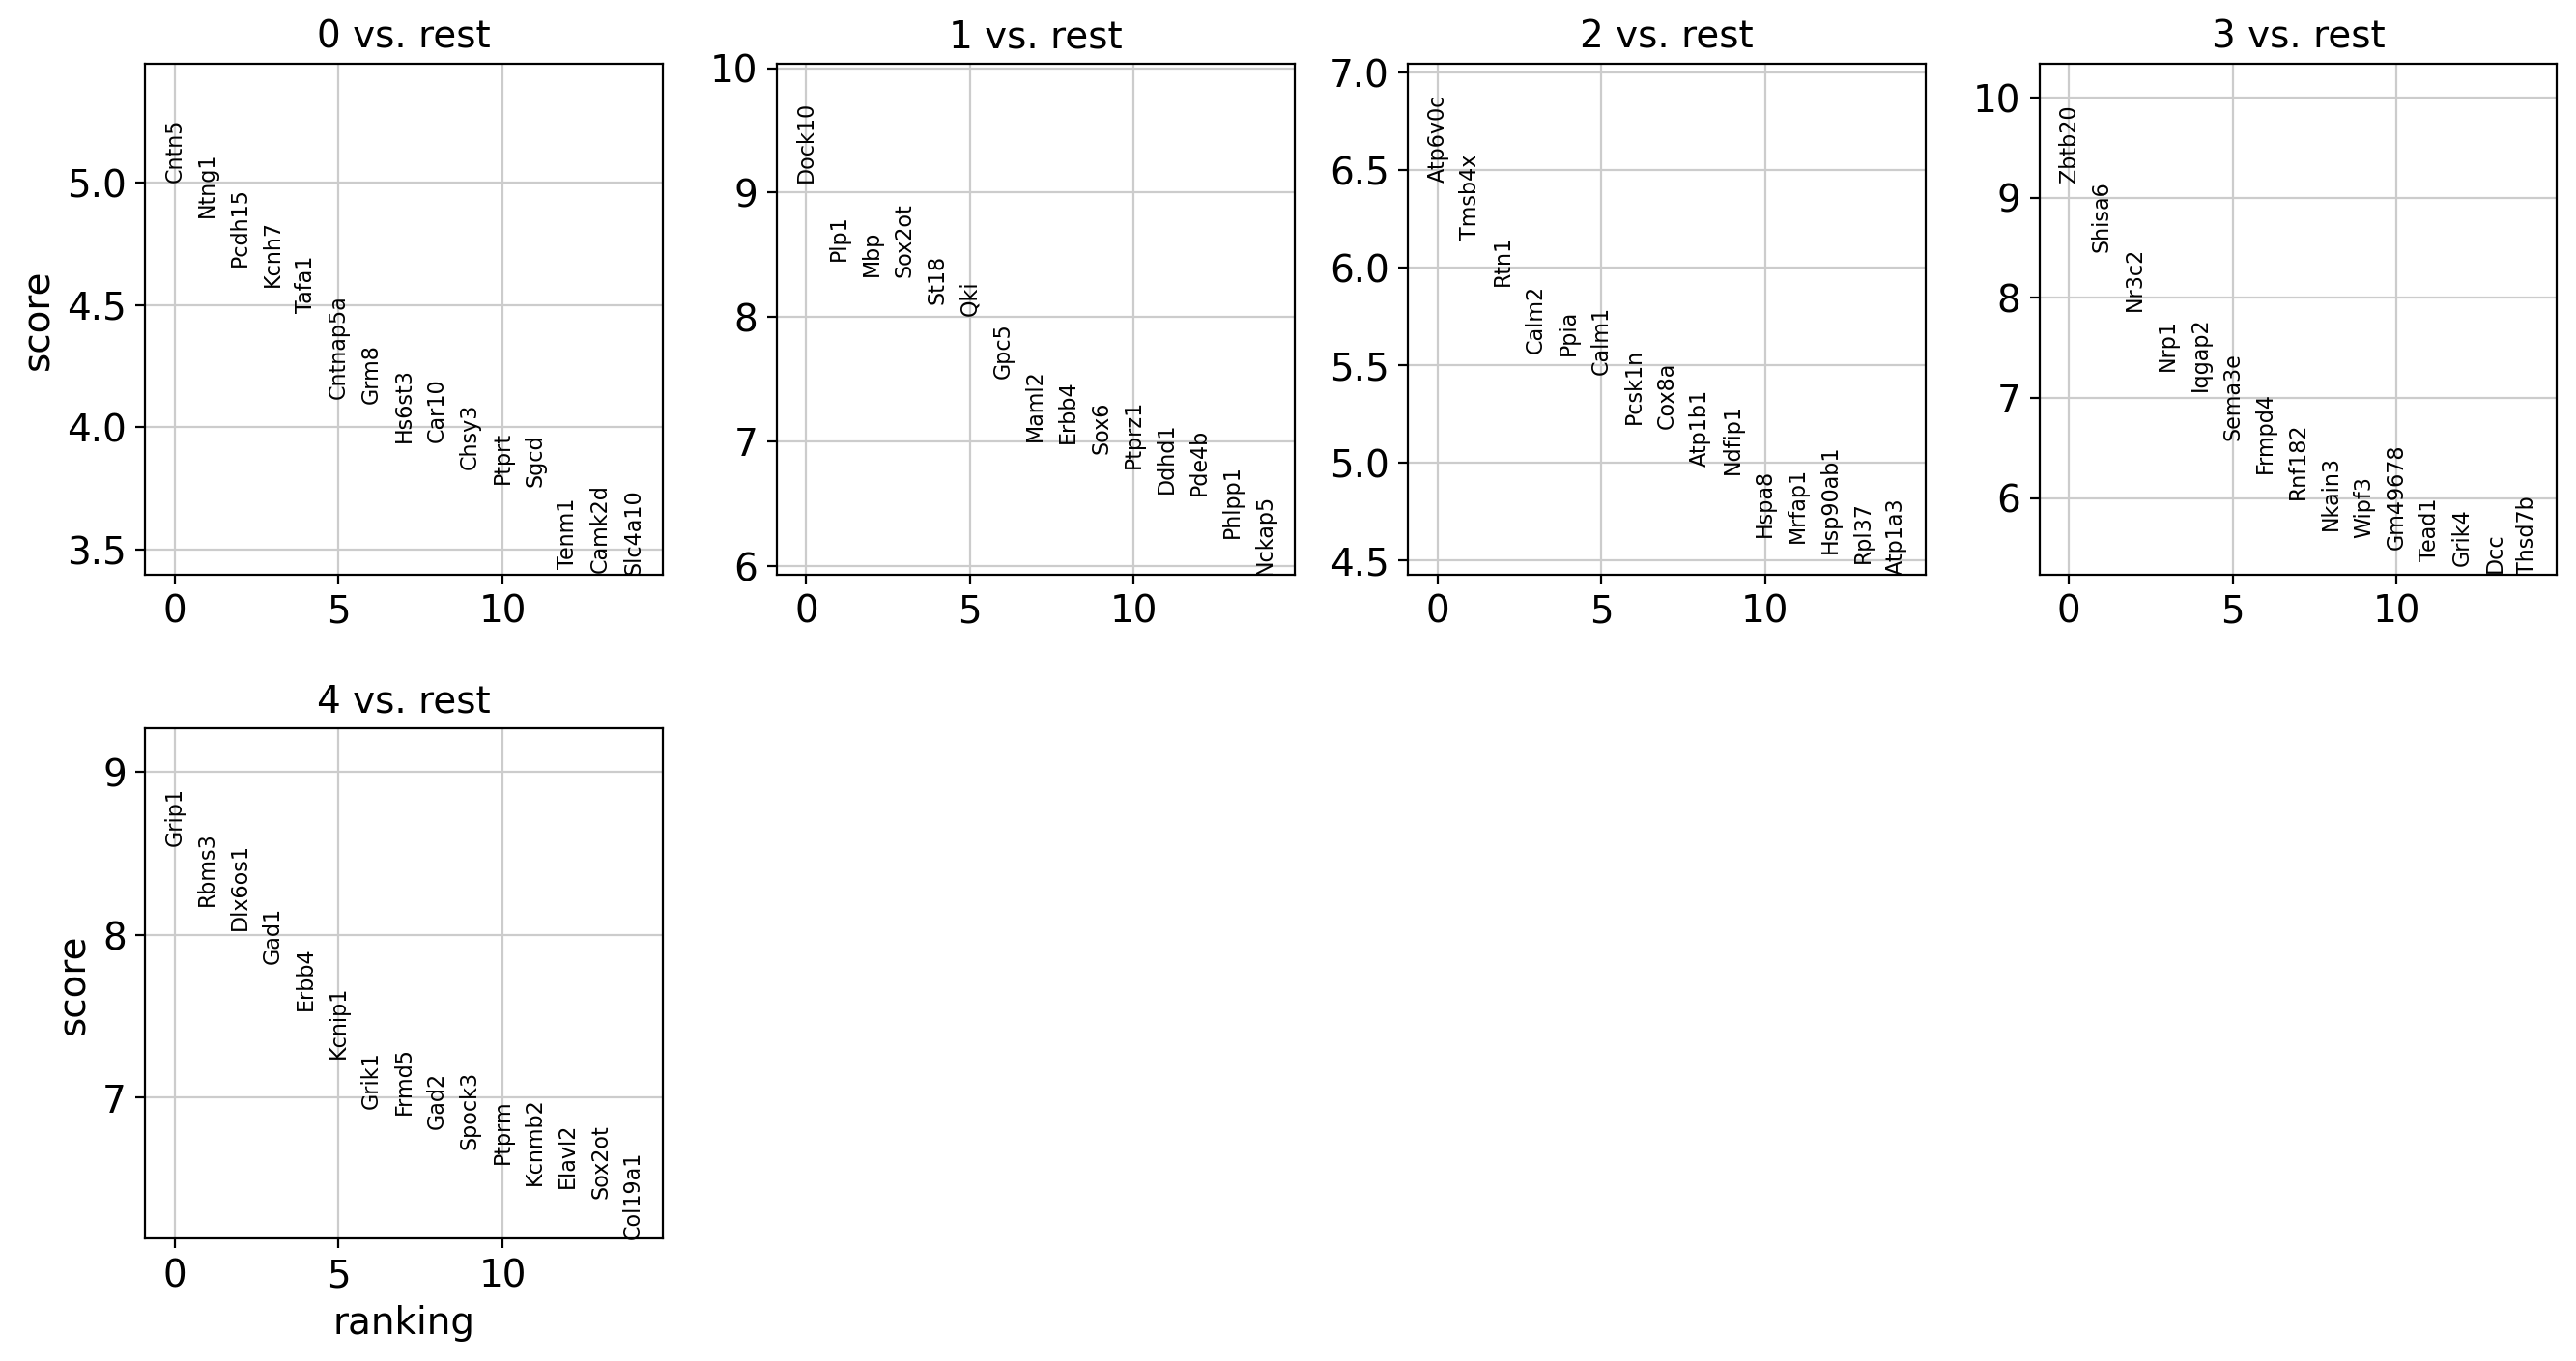

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/tmp/ipykernel_1946436/1174503536.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x1000 with 0 Axes>

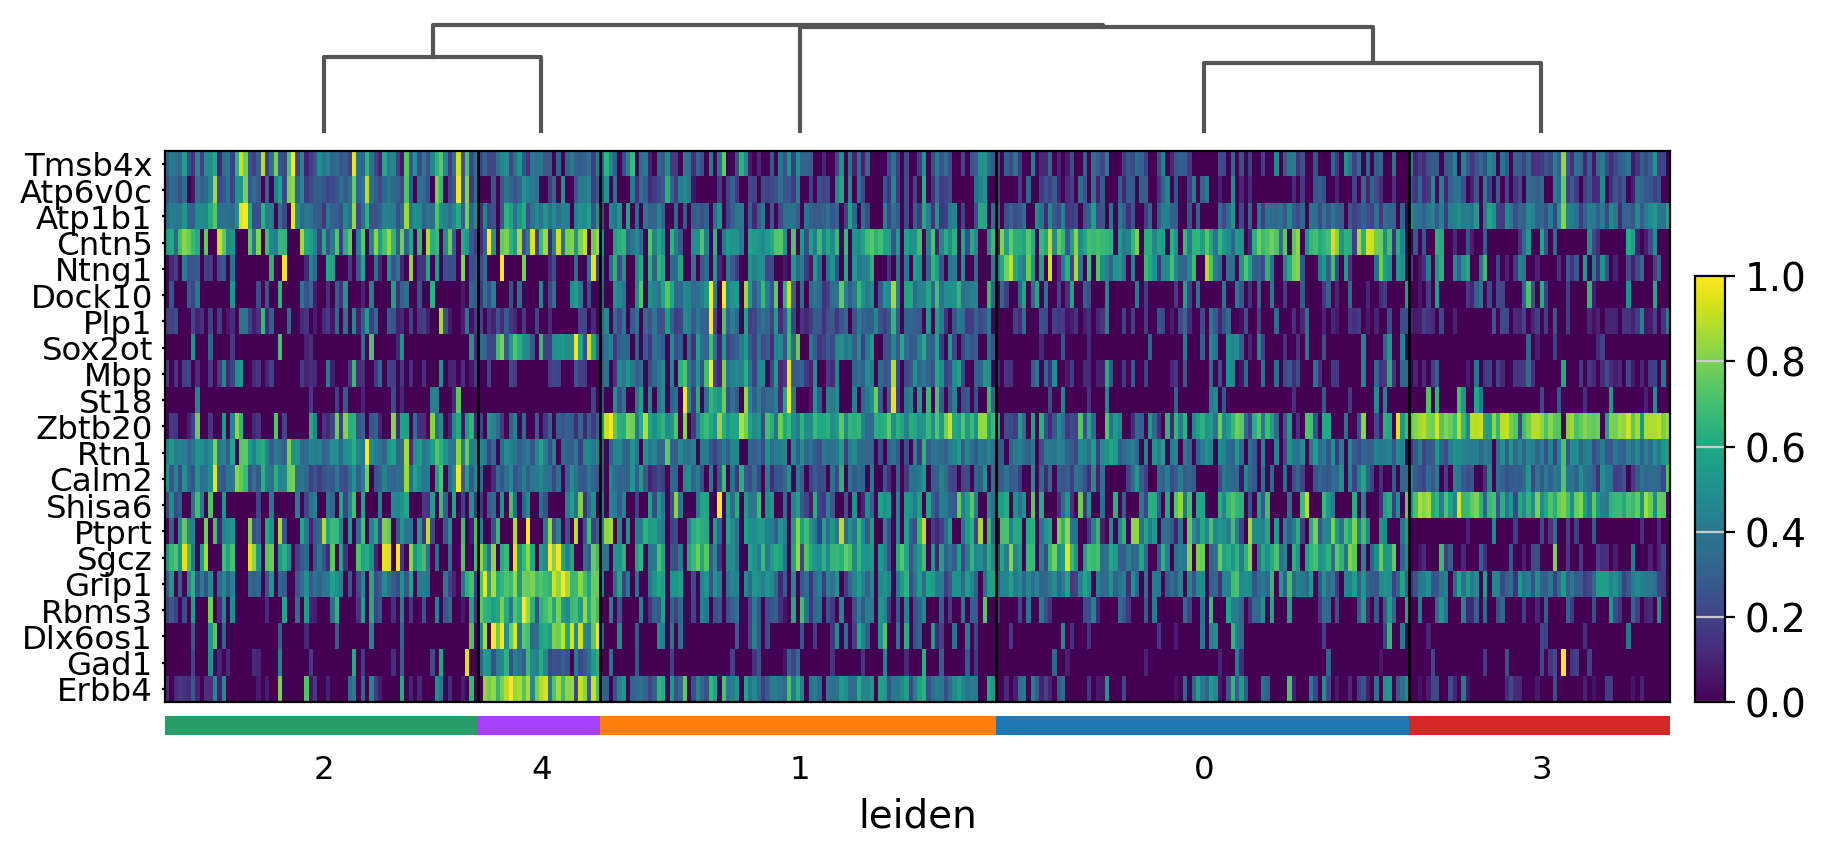

In [11]:
# Find marker genes for each cluster
# It's crucial to logarithmize the data *before* ranking genes.
# Since we already did log1p transformation, we proceed.
sc.tl.rank_genes_groups(adata_hvg, 'leiden', method='wilcoxon', use_raw=False)

# Plot top marker genes
plt.figure(figsize=(15, 10))
sc.pl.rank_genes_groups(adata_hvg, n_genes=15, sharey=False, show=False)
plt.tight_layout()
plt.show()

# Get the top markers for each cluster
marker_genes = pd.DataFrame()
for i in range(len(np.unique(adata_hvg.obs['leiden']))):
    markers = sc.get.rank_genes_groups_df(adata_hvg, group=str(i))
    markers = markers.sort_values('pvals_adj')
    markers['cluster'] = i
    marker_genes = pd.concat([marker_genes, markers.head(10)])

# Save markers to CSV
marker_genes.to_csv('cluster_markers.csv', index=False)

# Heatmap of top markers per cluster
top_markers_per_cluster = {}
for cluster in np.unique(adata_hvg.obs['leiden']):
    cluster_markers = marker_genes[marker_genes['cluster'] == int(cluster)]
    top_markers_per_cluster[cluster] = cluster_markers['names'].tolist()[:5]

markers_flat = [gene for cluster_markers in top_markers_per_cluster.values() for gene in cluster_markers]
markers_unique = list(dict.fromkeys(markers_flat))  # Remove duplicates while preserving order

# Run dendrogram to avoid warning
sc.tl.dendrogram(adata_hvg, groupby='leiden')

plt.figure(figsize=(15, 10))
# error was likely caused by the layer='log1p' argument, which expects the data
# to be in the .layers attribute. Since we already have log1p transformed data in .X,
# we should use that directly and avoid specifying a layer.  Also, use_raw=False is important
# because we are using the already processed data.

try:
    sc.pl.heatmap(adata_hvg, markers_unique, groupby='leiden', dendrogram=True, 
                  swap_axes=True, use_raw=False, show=False, standard_scale='var')
    plt.tight_layout()
    plt.show()
except KeyError as e:
    print(f"KeyError encountered: {e}")
    print("Check if the marker genes are in adata_hvg.var_names.")
    
    # Find missing genes
    missing_genes = [gene for gene in markers_unique if gene not in adata_hvg.var_names]
    print(f"Missing genes: {missing_genes}")
    
    # Proceed with available genes, if any
    available_markers = [gene for gene in markers_unique if gene in adata_hvg.var_names]
    if available_markers:
        print("Plotting heatmap with available markers.")
        sc.pl.heatmap(adata_hvg, available_markers, groupby='leiden', dendrogram=True, 
                      swap_axes=True, use_raw=False, show=False, standard_scale='var')
        plt.tight_layout()
        plt.show()
    else:
        print("No valid marker genes found in adata_hvg.var_names. Heatmap cannot be plotted.")

# 8. Cell Type Annotation

<Figure size 800x600 with 0 Axes>

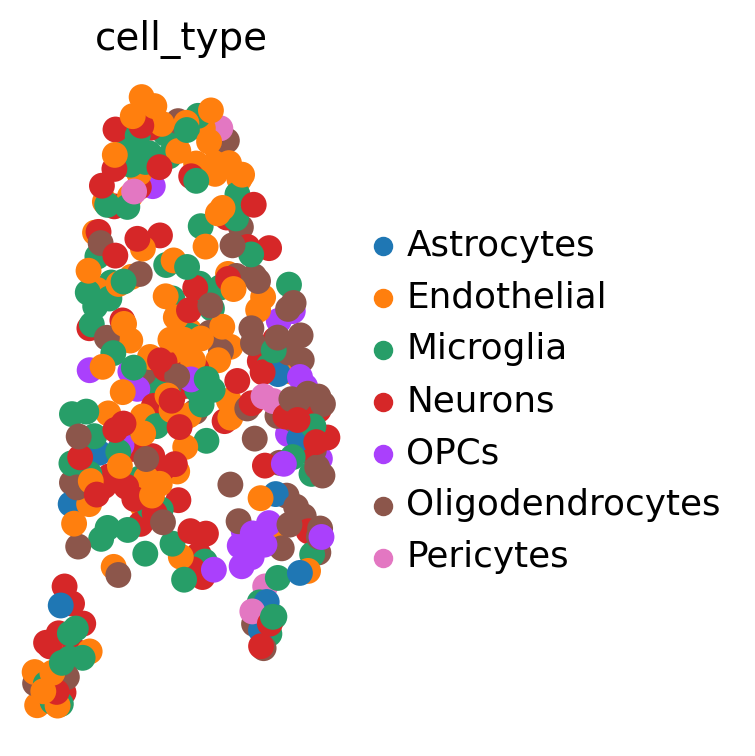

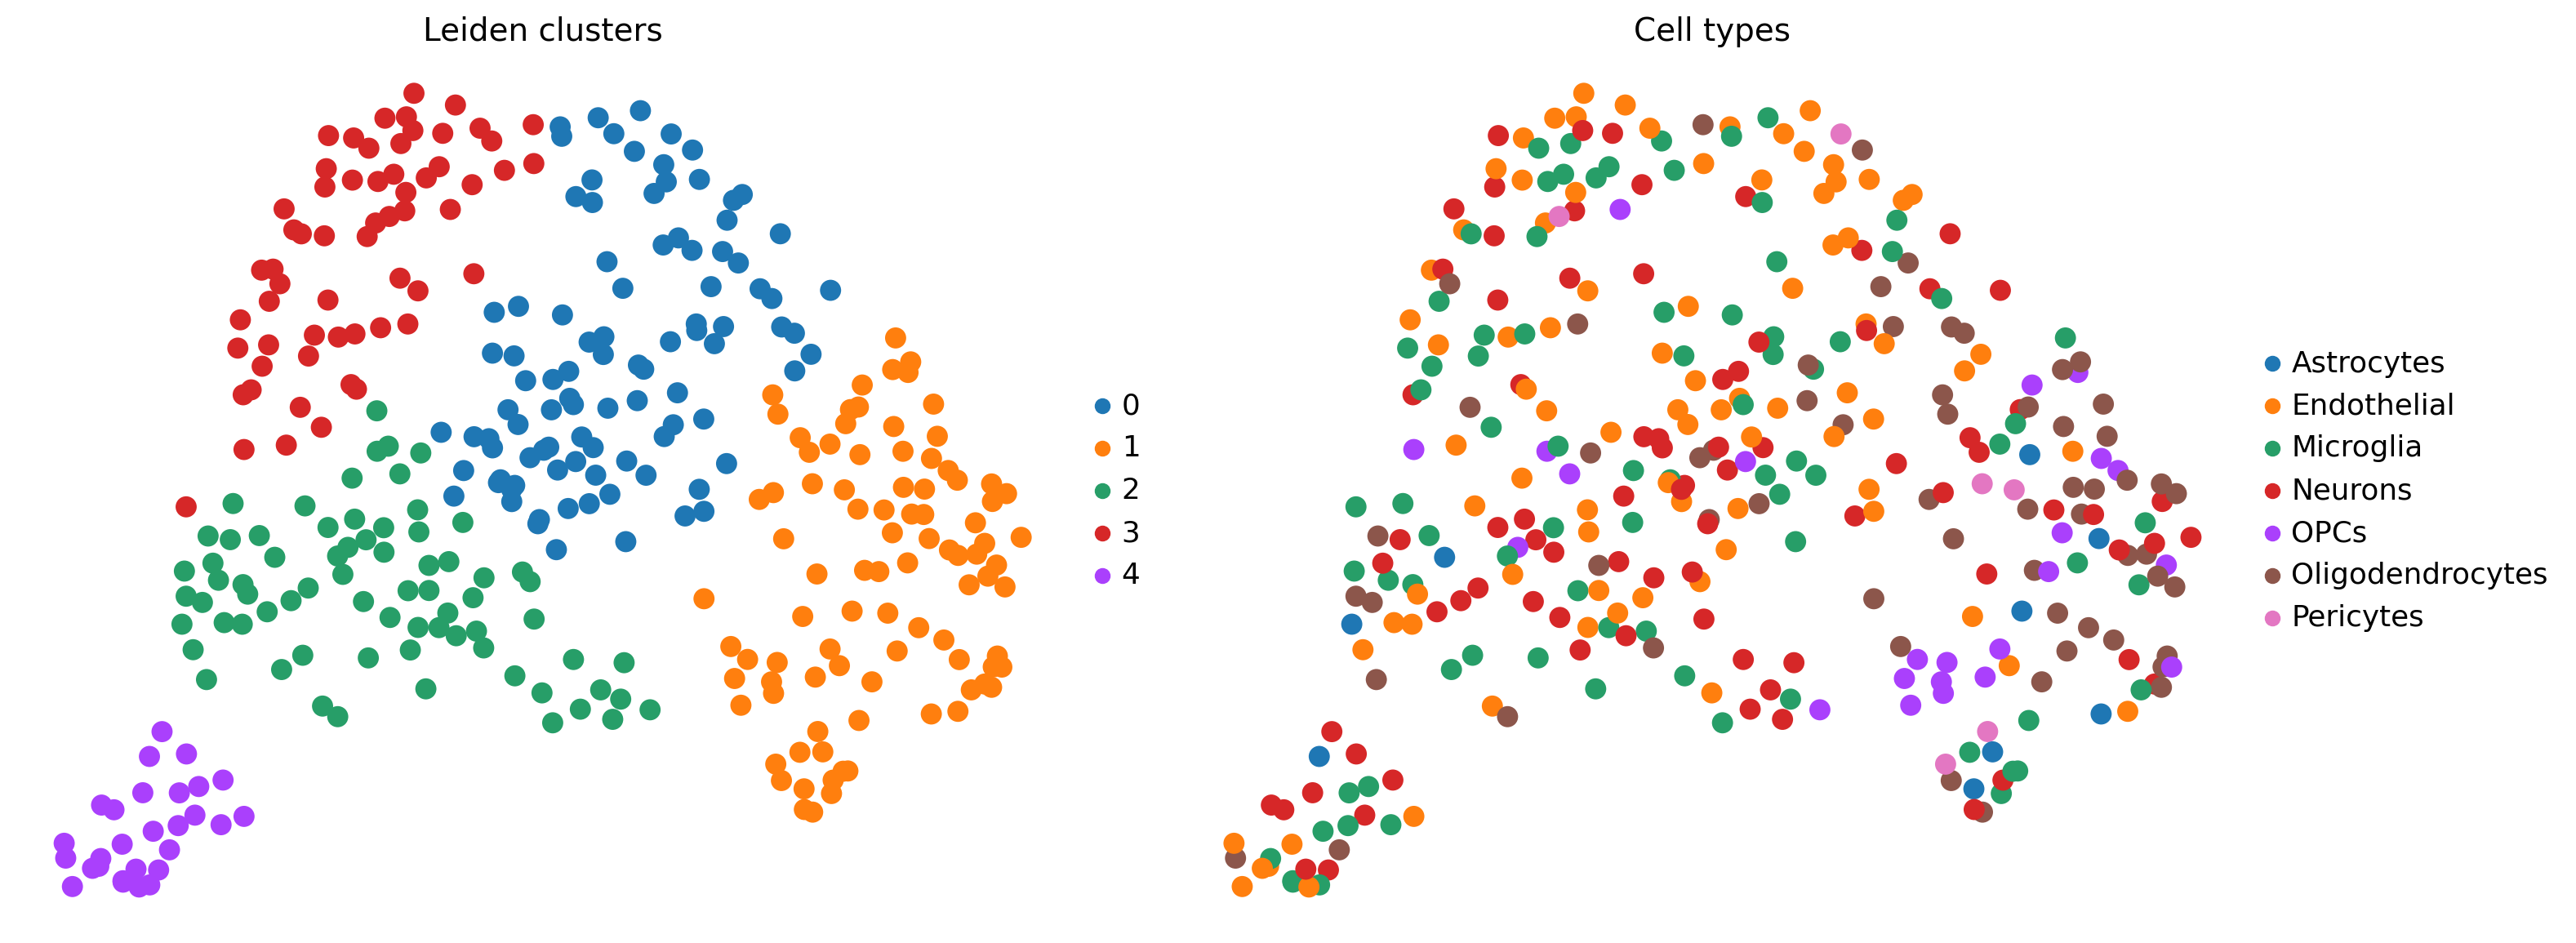

In [12]:
# Example of a basic function to annotate cell types based on known markers
def annotate_cell_types(adata):
    # Define known markers for cell types (adjust based on your organism/tissue)
    cell_type_markers = {
        'Neurons': ['Rbfox3', 'Tubb3', 'Map2', 'Snap25'],
        'Astrocytes': ['Gfap', 'Aqp4', 'Aldh1l1'],
        'Oligodendrocytes': ['Mbp', 'Plp1', 'Mog', 'Olig1', 'Olig2'],
        'Microglia': ['Cx3cr1', 'P2ry12', 'Hexb', 'Csf1r'],
        'OPCs': ['Pdgfra', 'Cspg4'],
        'Endothelial': ['Cldn5', 'Pecam1', 'Vwf'],
        'Pericytes': ['Pdgfrb', 'Rgs5', 'Acta2']
    }
    
    # Create a new dataframe to store scores
    cell_type_scores = pd.DataFrame(index=adata.obs_names)
    
    # For each cell type, calculate the mean expression of marker genes
    for cell_type, markers in cell_type_markers.items():
        # Find markers that exist in the dataset
        existing_markers = [marker for marker in markers if marker in adata.var_names]
        if len(existing_markers) > 0:
            # Calculate mean expression of markers for each cell
            cell_type_scores[cell_type] = adata[:, existing_markers].X.mean(axis=1)
    
    # Assign cell type based on highest score
    adata.obs['cell_type'] = cell_type_scores.idxmax(axis=1)
    
    # Add score for visualization
    adata.obs['cell_type_score'] = cell_type_scores.max(axis=1)
    
    return adata

# Annotate cell types
adata_hvg = annotate_cell_types(adata_hvg)

# Plot cell types on UMAP
plt.figure(figsize=(8, 6))
sc.pl.umap(adata_hvg, color='cell_type', show=False)
plt.tight_layout()
plt.show()

# Compare with Leiden clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sc.pl.umap(adata_hvg, color='leiden', title='Leiden clusters', ax=axes[0], show=False)
sc.pl.umap(adata_hvg, color='cell_type', title='Cell types', ax=axes[1], show=False)
plt.tight_layout()
plt.show()

# 9. Differential Expression Analysis

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


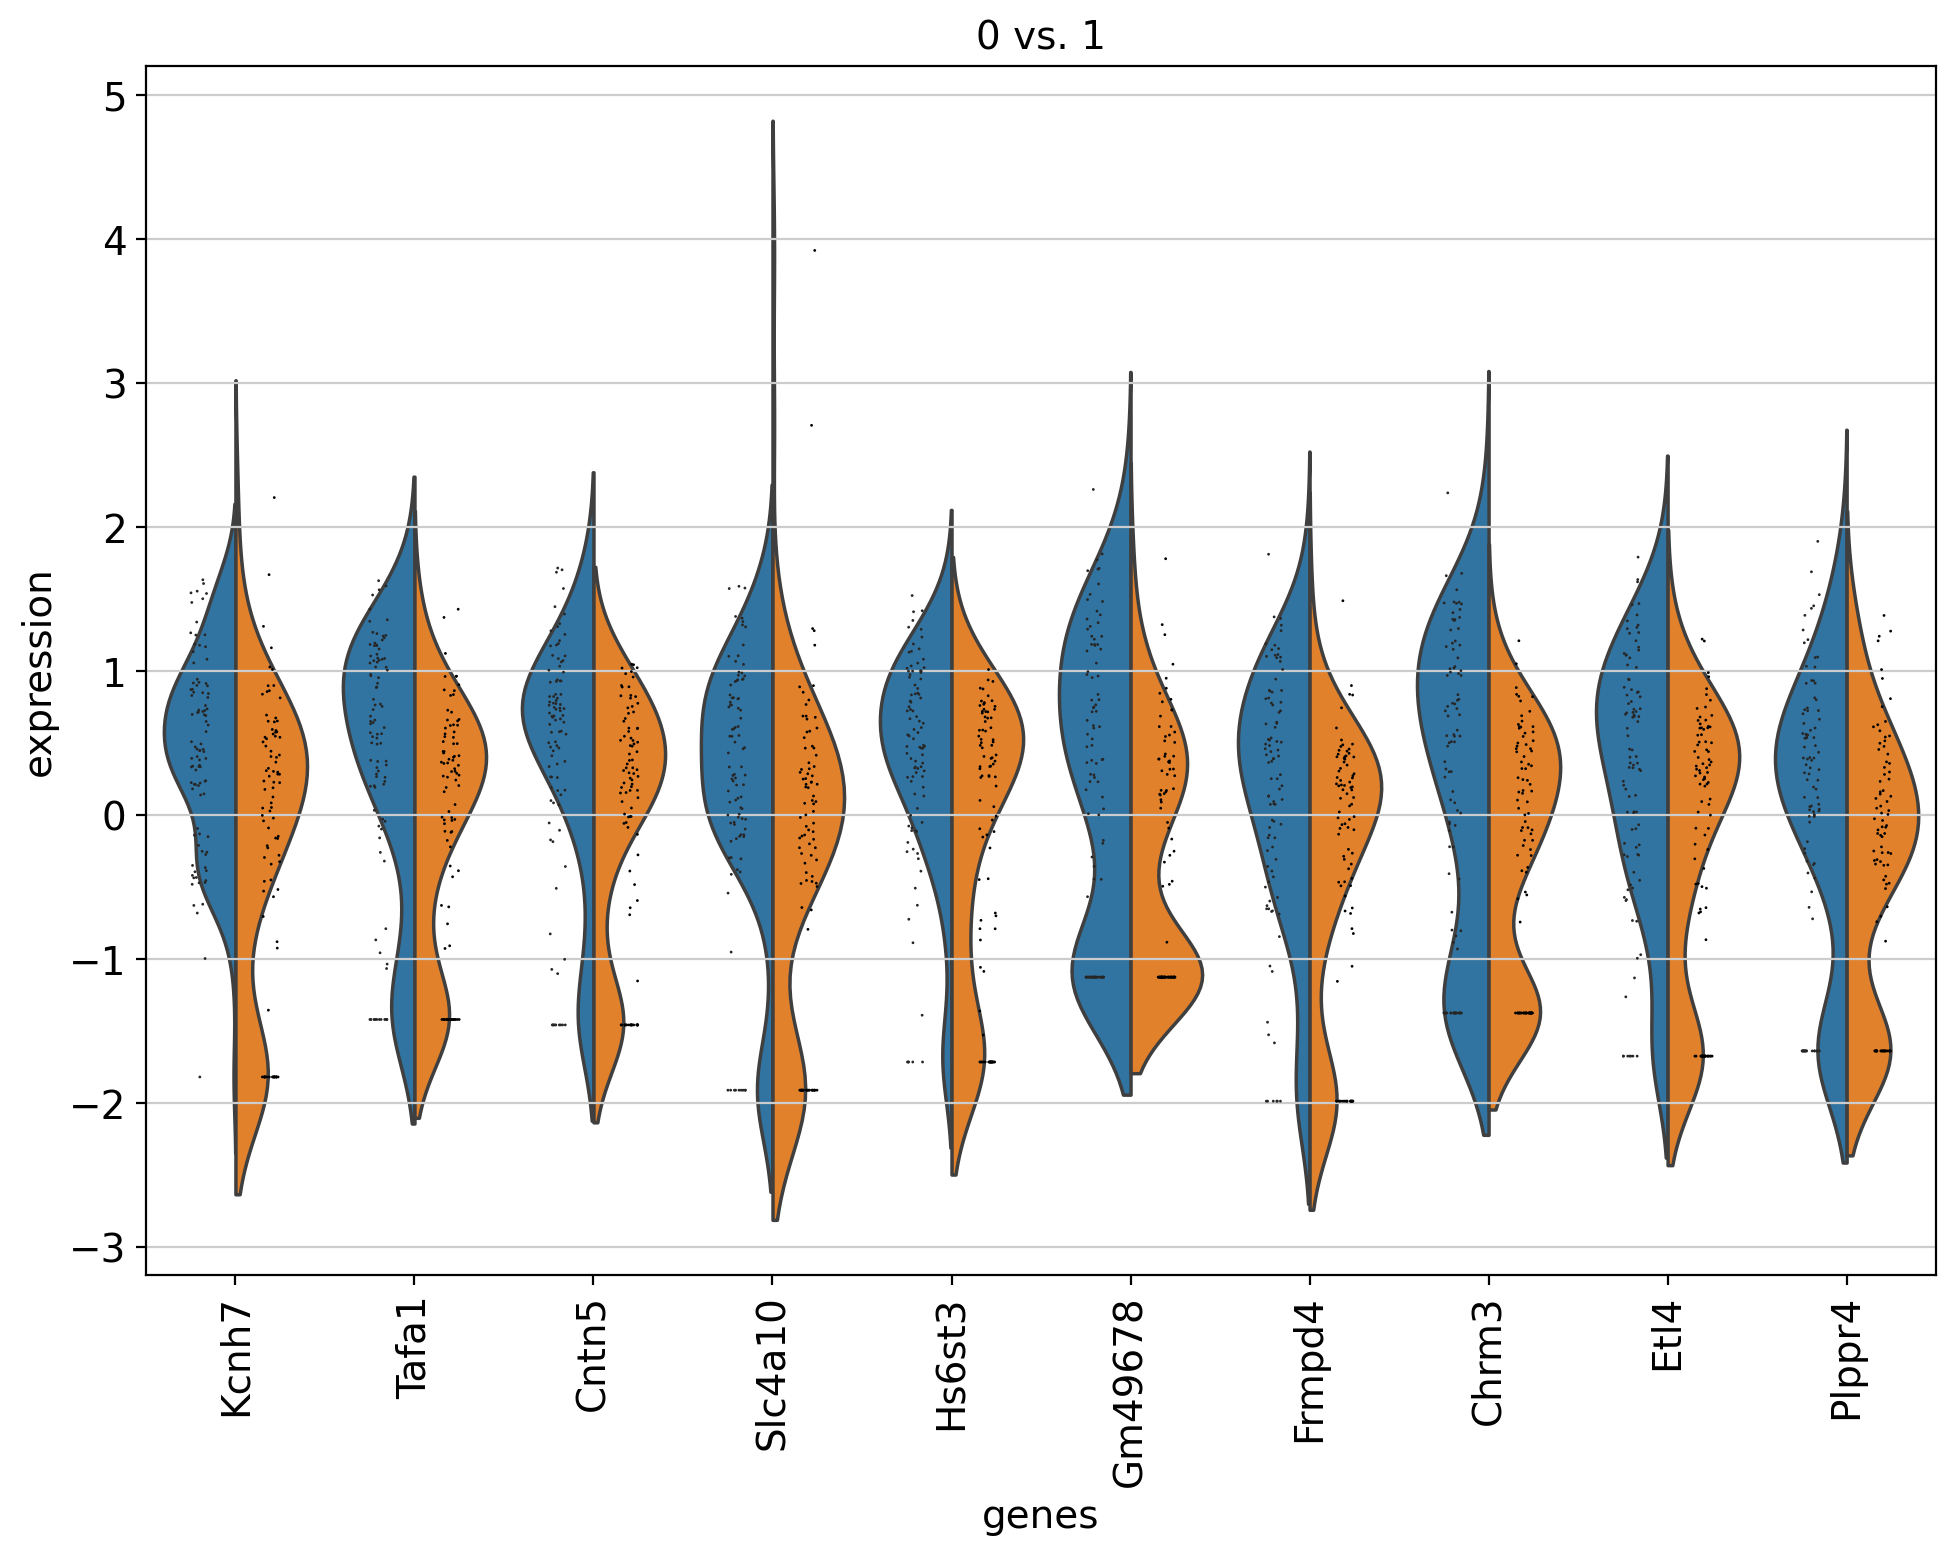

            names    scores  logfoldchanges     pvals  pvals_adj
0           Kcnh7  4.122173             NaN  0.000038   0.004321
1           Tafa1  4.107189             NaN  0.000040   0.004496
2           Cntn5  4.082668       11.945045  0.000045   0.004876
3         Slc4a10  3.923285             NaN  0.000087   0.007844
4          Hs6st3  3.887866             NaN  0.000101   0.008108
5         Gm49678  3.604518             NaN  0.000313   0.022288
6          Frmpd4  3.577273             NaN  0.000347   0.023408
7           Chrm3  3.495538             NaN  0.000473   0.029099
8            Etl4  3.461481             NaN  0.000537   0.030688
9          Plppr4  3.295287             NaN  0.000983   0.050166
10  A830018L16Rik  3.216276             NaN  0.001299   0.061379
11          Epha3  2.965622             NaN  0.003021   0.109565
12          Chsy3  2.960173             NaN  0.003075   0.109565
13          Kcnq5  2.913856             NaN  0.003570   0.122106
14           Grm8  2.9111

In [13]:
# Perform differential expression between two groups (e.g., clusters 0 and 1)
sc.tl.rank_genes_groups(adata_hvg, 'leiden', groups=['0'], reference='1', method='wilcoxon', use_raw=False)

# Plot results
plt.figure(figsize=(10, 8))
sc.pl.rank_genes_groups_violin(adata_hvg, groups=['0'], n_genes=10, show=False)
plt.tight_layout()
plt.show()

# Get differential expression results as dataframe
de_genes = sc.get.rank_genes_groups_df(adata_hvg, group='0', key='rank_genes_groups')
print(de_genes.head(20))

# 10. Save Results

In [14]:
OUT_DIR = "post_analysis/results"
os.makedirs(os.path.join(OUT_DIR, SAMPLE), exist_ok=True)

# Save the processed object for future use
adata_hvg.write(os.path.join(OUT_DIR, SAMPLE, 'R26_Nestin_Mut_adult_processed.h5ad'))

# Save key results to CSV files
adata_hvg.obs.to_csv(os.path.join(OUT_DIR, SAMPLE, 'cell_metadata.c     sv'))
pd.DataFrame({'UMAP1': adata_hvg.obsm['X_umap'][:, 0], 
              'UMAP2': adata_hvg.obsm['X_umap'][:, 1], 
              'cluster': adata_hvg.obs['leiden'],
              'cell_type': adata_hvg.obs['cell_type']}).to_csv(os.path.join(OUT_DIR, SAMPLE, 'umap_coordinates.csv'), index=False)

# Generate summary report
summary = {
    'total_cells': adata_hvg.n_obs,
    'total_genes': adata_hvg.n_vars,
    'clusters': len(np.unique(adata_hvg.obs['leiden'])),
    'cell_types': len(np.unique(adata_hvg.obs['cell_type'])),
    'cells_per_cluster': adata_hvg.obs['leiden'].value_counts().to_dict(),
    'cells_per_cell_type': adata_hvg.obs['cell_type'].value_counts().to_dict()
}

with open(os.path.join(OUT_DIR, SAMPLE, 'analysis_summary.txt'), 'w') as f:
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")